# Ranked-batch Active Learning

Authors: Domicio Neto, Tiago Conceição

In [1]:
import numpy as np
import pandas as pd
import math

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from functools import partial
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

Place the **pumpDataFeatures.csv** file in the directory of this notebook.

### Experiment parameters

Use the parameters below to replicate the results we obtained.

In [2]:
parameters = [[5,621],[5,984],[5,162],[5,344],[5,156],
             [10,621],[10,984],[10,162],[10,344],[10,156],
             [20,621],[20,984],[20,162],[20,344],[20,156],
             [25,621],[25,984],[25,162],[25,344],[25,156]]
p_idx = 0

In [3]:
# remember, the number of samples to be queried must be divisible by the batch size
BATCH_SIZE, RANDOM_STATE_SEED = parameters[p_idx]
N_SAMPLES = 50
N_QUERIES = int(N_SAMPLES/BATCH_SIZE)

In [4]:
print("Batch size: "+str(BATCH_SIZE))
print("Number of queries: "+str(N_QUERIES))
print("Seed: "+str(RANDOM_STATE_SEED))

Batch size: 5
Number of queries: 10
Seed: 621


### Setting the seed to reproduce the same results

In [5]:
np.random.seed(RANDOM_STATE_SEED)

### Importing and preparing the dataset

In [6]:
dataset_original = pd.read_csv("pumpDataFeatures.csv")

#### Example from the dataset

In [7]:
dataset_original

,faultCode,flow_stats/Data_ClearanceFactor,flow_stats/Data_CrestFactor,flow_stats/Data_ImpulseFactor,flow_stats/Data_Kurtosis,flow_stats/Data_Mean,flow_stats/Data_PeakValue,flow_stats/Data_RMS,flow_stats/Data_SINAD,flow_stats/Data_SNR,...,pressure_ps_spec/Data_PeakFreq5,pressure_ps_spec/Data_Wn1,pressure_ps_spec/Data_Wn2,pressure_ps_spec/Data_Wn3,pressure_ps_spec/Data_Wn4,pressure_ps_spec/Data_Zeta1,pressure_ps_spec/Data_Zeta2,pressure_ps_spec/Data_Zeta3,pressure_ps_spec/Data_Zeta4,pressure_ps_spec/Data_BandPower
0,0,1.163391,1.157736,1.161464,2.411256,38.425683,44.630042,38.549398,-1.859601,-1.638197,...,197.344375,48.207771,96.038369,146.757076,NaN,0.027078,0.008036,0.026561,NaN,0.000311
1,0,1.155002,1.149543,1.153142,2.401777,38.430092,44.315342,38.550391,-0.766921,-0.502252,...,197.737767,48.335174,96.130586,147.535844,280.031243,0.027930,0.008919,0.035015,0.001315,0.000316
2,100,1.139845,1.134447,1.138003,2.521911,38.107923,43.366923,38.227375,-1.165394,-1.044432,...,245.180239,47.842206,95.379830,145.621203,191.867557,0.031275,0.009333,0.040380,0.032653,0.000313
3,100,1.161095,1.155509,1.159191,2.379006,37.173210,43.090842,37.291647,-1.438353,-1.148977,...,243.264930,47.061263,93.293689,145.011475,189.426438,0.050114,0.013187,0.056640,0.045693,0.000271
4,100,1.155750,1.150469,1.153952,2.367804,38.105157,43.971526,38.220509,-1.785390,-1.552011,...,197.367821,47.891793,95.319000,146.999946,267.203167,0.031247,0.009139,0.030858,0.010233,0.000313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,100,1.146129,1.140671,1.144268,2.412568,37.155652,42.516014,37.272818,-1.270555,-0.992189,...,243.459346,47.107129,93.193350,141.077958,NaN,0.051137,0.012350,0.069070,NaN,0.000286
236,100,1.148484,1.143093,1.146647,2.416922,37.038475,42.470058,37.153642,-1.179148,-0.794501,...,243.148178,46.951055,93.049051,142.786666,NaN,0.053929,0.014436,0.052553,NaN,0.000285
237,100,1.166223,1.160635,1.164320,2.359408,37.636771,43.821246,37.756276,-0.809155,-0.494147,...,243.809088,47.368669,94.225331,144.974469,NaN,0.041765,0.011243,0.043999,NaN,0.000311
238,100,1.139716,1.134204,1.137837,2.378374,38.209404,43.476085,38.331813,-0.949510,-0.526268,...,199.364386,48.228289,95.763336,146.453312,190.555999,0.032764,0.009876,0.037890,0.112334,0.000309


### Counting the number of samples of each class

In [8]:
class_names = ['None','Leak','Blocking','Leak & Blocking','Bearing','Bearing & Leak','Bearing & Blocking','All']
count_classes = pd.DataFrame(dataset_original['faultCode'].value_counts())
count_classes.sort_index(inplace=True)
count_classes['labels'] = class_names
count_classes.set_index('labels',inplace=True)
count_classes

,faultCode
labels,
None,42
Leak,27
Blocking,41
Leak & Blocking,17
Bearing,40
Bearing & Leak,24
Bearing & Blocking,32
All,17


The dataset is not balanced

<AxesSubplot:xlabel='labels'>

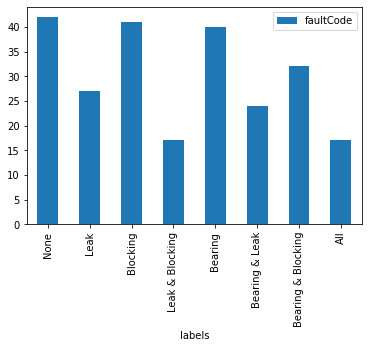

In [9]:
count_classes.plot.bar()

In [10]:
# Droping columns with many missing values
dataset_original.drop(["pressure_ps_spec/Data_Zeta4","pressure_ps_spec/Data_Wn4","pressure_ps_spec/Data_PeakFreq5","pressure_ps_spec/Data_PeakAmp5","flow_ps_spec/Data_Zeta4","flow_ps_spec/Data_PeakFreq5"], axis=1, inplace=True)

In [11]:
# Replacing missing values by the average
for col in dataset_original.columns:
    tmp_avg = dataset_original[col].mean()
    dataset_original[col].fillna(tmp_avg, inplace=True)

In [12]:
dataset_original.isna().sum().sum()

0

#### Preparing the samples and labels

First we separate the samples and labels from the raw dataset.

In [13]:
X_default = dataset_original.iloc[:,1:].to_numpy()
Y_default = dataset_original["faultCode"].to_numpy()

In [14]:
# X_default shape is number of samples x number of features
print(X_default.shape)

(240, 57)


In [15]:
# labels
print(Y_default.shape)

(240,)


### Creating the training sets

Now we create the training sets for the active learner and for the baseline classifier. A first split is done, 15% of the data is set for testing both baseline and active learner. The remaining 85% is used for training the baseline. These 85% is split again in a 40/60 split. The first half is used for training the active learner. The second half is used as the sample pool from where the active learner will make queries during the active learning loop. 

In [16]:
sss_3 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=RANDOM_STATE_SEED)

In [17]:
for train_index, test_index in sss_3.split(X_default, Y_default):
    X_train_baseline, X_test_baseline = X_default[train_index], X_default[test_index]
    y_train_baseline, y_test_baseline = Y_default[train_index], Y_default[test_index]

In [18]:
X_train_baseline.shape

(204, 57)

In [19]:
X_test_baseline.shape

(36, 57)

In [20]:
sss_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=RANDOM_STATE_SEED)

In [21]:
for train_index, test_index in sss_1.split(X_train_baseline, y_train_baseline):
    X_train, X_pool = X_train_baseline[train_index], X_train_baseline[test_index]
    y_train, y_pool = y_train_baseline[train_index], y_train_baseline[test_index]

In [22]:
X_train.shape

(81, 57)

In [23]:
X_pool.shape

(123, 57)

### Creating the baseline classifier

The baseline is a Random Forest classifier, also used as the active learner's estimator.

In [24]:
baseline_clf = RandomForestClassifier()
# training the classifier
baseline_clf.fit(X_train_baseline, y_train_baseline)

RandomForestClassifier()

In [25]:
y_pred_baseline = baseline_clf.predict(X_test_baseline)
baseline_score = f1_score(y_test_baseline,y_pred_baseline,average='macro')
print("Baseline F1-score: "+str(baseline_score))

Baseline F1-score: 0.7747474747474747


### Initializing the learner

In [26]:
clf = RandomForestClassifier()

In [27]:
# pre-set our batch sampling to retrieve BATCH_SIZE samples at a time
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

In [28]:
# creating the active learner
learner = ActiveLearner(
    estimator=clf,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

In [29]:
# score
y_pred = learner.estimator.predict(X_test_baseline)
score = f1_score(y_test_baseline,y_pred,average='macro')
performance_history = [score]
print("Macro F1-Score: "+str(score))

Macro F1-Score: 0.6670634920634921


### Active learning loop

Here is where the Active Learning happens. At each iteration, the learner queries a batch of samples and receives the correct labels. Then the learner trains the estimator again with the new learned samples. Finally, we calculate the performance on the test set at the end of each iteration.

In [30]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # teach our ActiveLearner model the batch it has requested
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # remove the queried instances from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # calculate our model's closed set performance
    y_pred = learner.estimator.predict(X_test_baseline)
    model_f1_score = f1_score(y_test_baseline,y_pred,average='macro')
    # calculate our model's open set performance
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f1_score))
    # save our model's performance for plotting
    performance_history.append(model_f1_score)

Accuracy after query 1: 0.7565
Accuracy after query 2: 0.7565
Accuracy after query 3: 0.7829
Accuracy after query 4: 0.7842
Accuracy after query 5: 0.8247
Accuracy after query 6: 0.7747
Accuracy after query 7: 0.8486
Accuracy after query 8: 0.7747
Accuracy after query 9: 0.8986
Accuracy after query 10: 0.8486


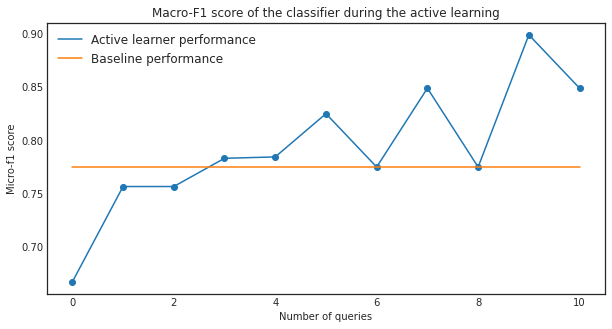

In [31]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Macro-F1 score of the classifier during the active learning')    
    plt.plot(range(N_QUERIES+1), performance_history)
    plt.scatter(range(N_QUERIES+1), performance_history)
    plt.plot(range(N_QUERIES+1), np.repeat(baseline_score, N_QUERIES+1))
    plt.legend(['Active learner performance','Baseline performance'], fontsize = 'large')
    plt.xlabel('Number of queries')
    plt.ylabel('Micro-f1 score')
    plt.show()

### Save results

In [32]:
np.save("Results/performanceb"+str(BATCH_SIZE)+"seed"+str(p_idx%5)+".npy",performance_history)

In [33]:
np.save("Results/performancebaselineseed"+str(p_idx%5)+".npy",baseline_score)

#### Just to check if everything is ok

In [34]:
#saved_closed = np.load("Results/performanceb"+str(BATCH_SIZE)+"closedseed"+str(p_idx%5)+".npy")

In [35]:
#print(saved_closed)

In [36]:
#saved_base_closed = np.load("Results/performancebaselineclosedseed"+str(p_idx%5)+".npy")

In [37]:
#print(saved_base_closed)